In [1]:
import torch, pyro.optim

from matplotlib import pyplot as plt

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy


torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
from libsimplesn import SimpleSN

simplesn = SimpleSN(survey='jla', datatype='photoz', N=1000, suffix=0, vitype='hpmvn')
config = simplesn.config(gen=False)
truths = torch.load(simplesn.data_name, map_location='cuda')

## Fit

In [3]:
losses = []
config.guide.setup(init=truths)
config.guide

Guide(
  (hpmvn): HierarchicPartialMultivariateNormalSamplingGroup(15 sites, torch.Size([4011]))
)

In [14]:
lrs = (
#     (1e-3, 1000, 1),
#     (1e-3, 5000, 4),
#     (1e-3, 5000, 4),
#     (1e-4, 5000, 4),
    (1e-4, 5000, 4),
)

for lr, n_steps, *args in lrs:
    num_particles, *_ = args + [1]
    losses += config.fit(lr=lr, n_steps=n_steps, loss_args=dict(num_particles=num_particles),
                         optimizer_cls=pyro.optim.Adam)
#                          optimizer_cls=pyro.optim.ClippedAdam, optimizer_args=dict(clip_norm=1.))

  0%|          | 0/5000 [00:00<?, ?it/s]

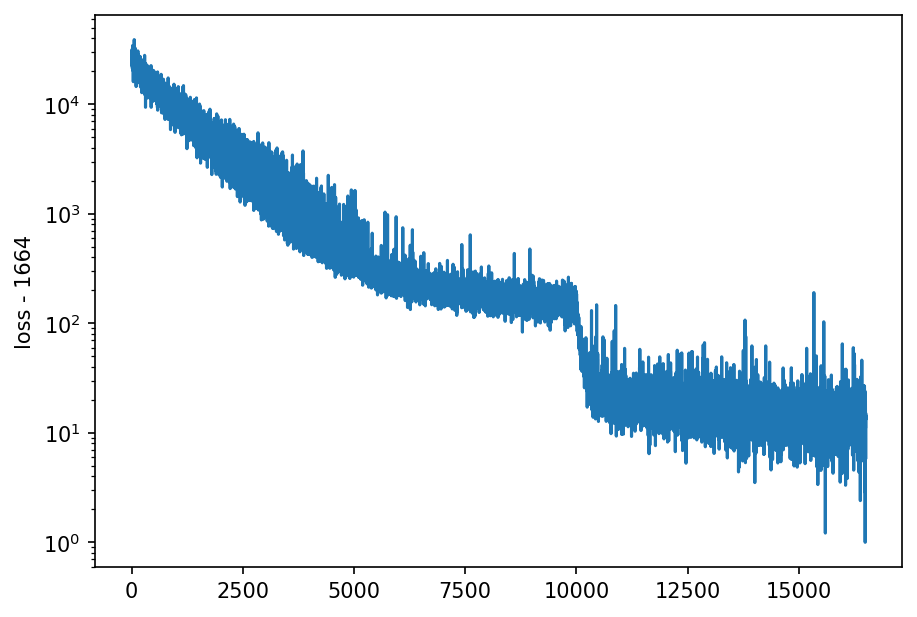

In [15]:
plt.semilogy((_ := torch.tensor(losses)) - _.amin() + 1);
plt.ylabel(f'loss - {float(_.min()):.0f}');

In [16]:
# simplesn.vi_losses = losses
# simplesn.vi_guide = config.guide

## Results

In [3]:
losses = simplesn.vi_losses
config.guide = simplesn.vi_guide

In [17]:
from clipppy.utils.plotting import HPMVNPlotter

plotter = HPMVNPlotter.from_guide(
    config.guide,
    names_global=(
        'Om0', 'Ode0', 'sigma_z',
        'alpha', 'beta',
        'mean_M0', 'sigma_res', 'mean_x1', 'log10_R_x1', 'mean_c', 'log10_R_c'
    ), names_hier=('M0', 'x1', 'c', 'z'),
    nsamples=10000, truths=truths
)

/usr/lib/python3.10/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


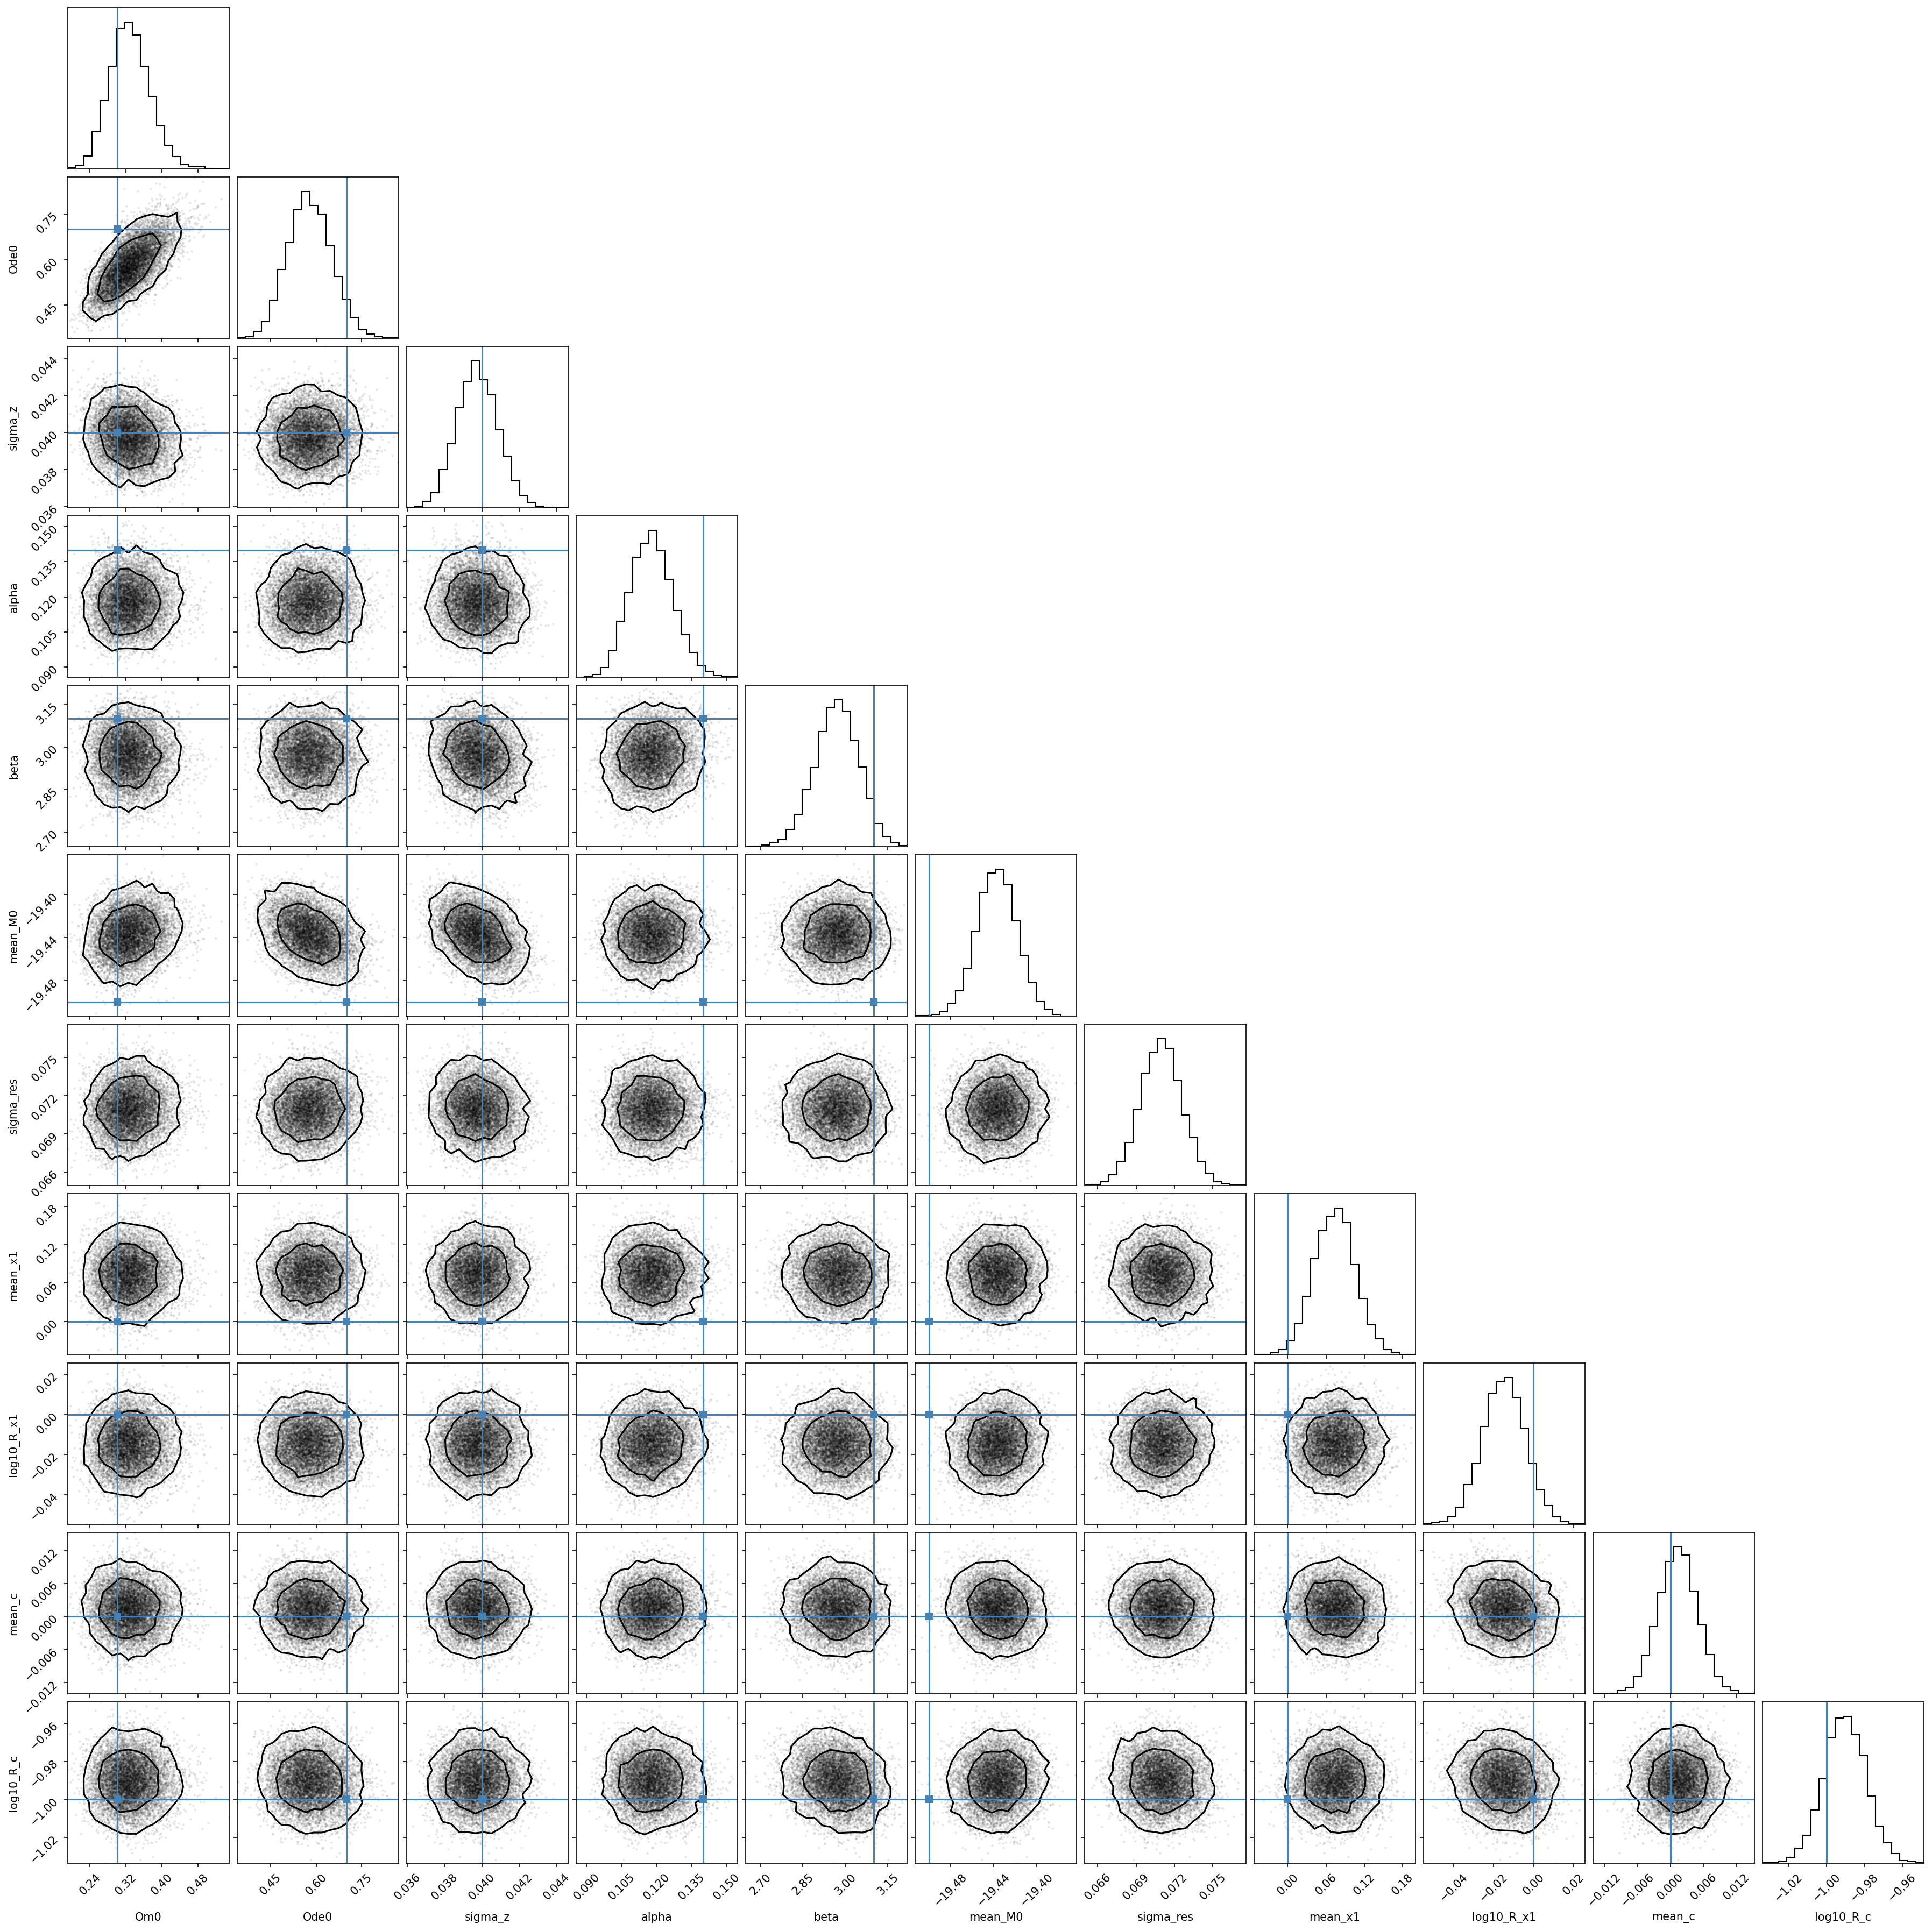

In [18]:
plotter.plot_corner();
# plt.savefig(simplesn.plotdir / (simplesn.vi_prefix + '-corner.png'));

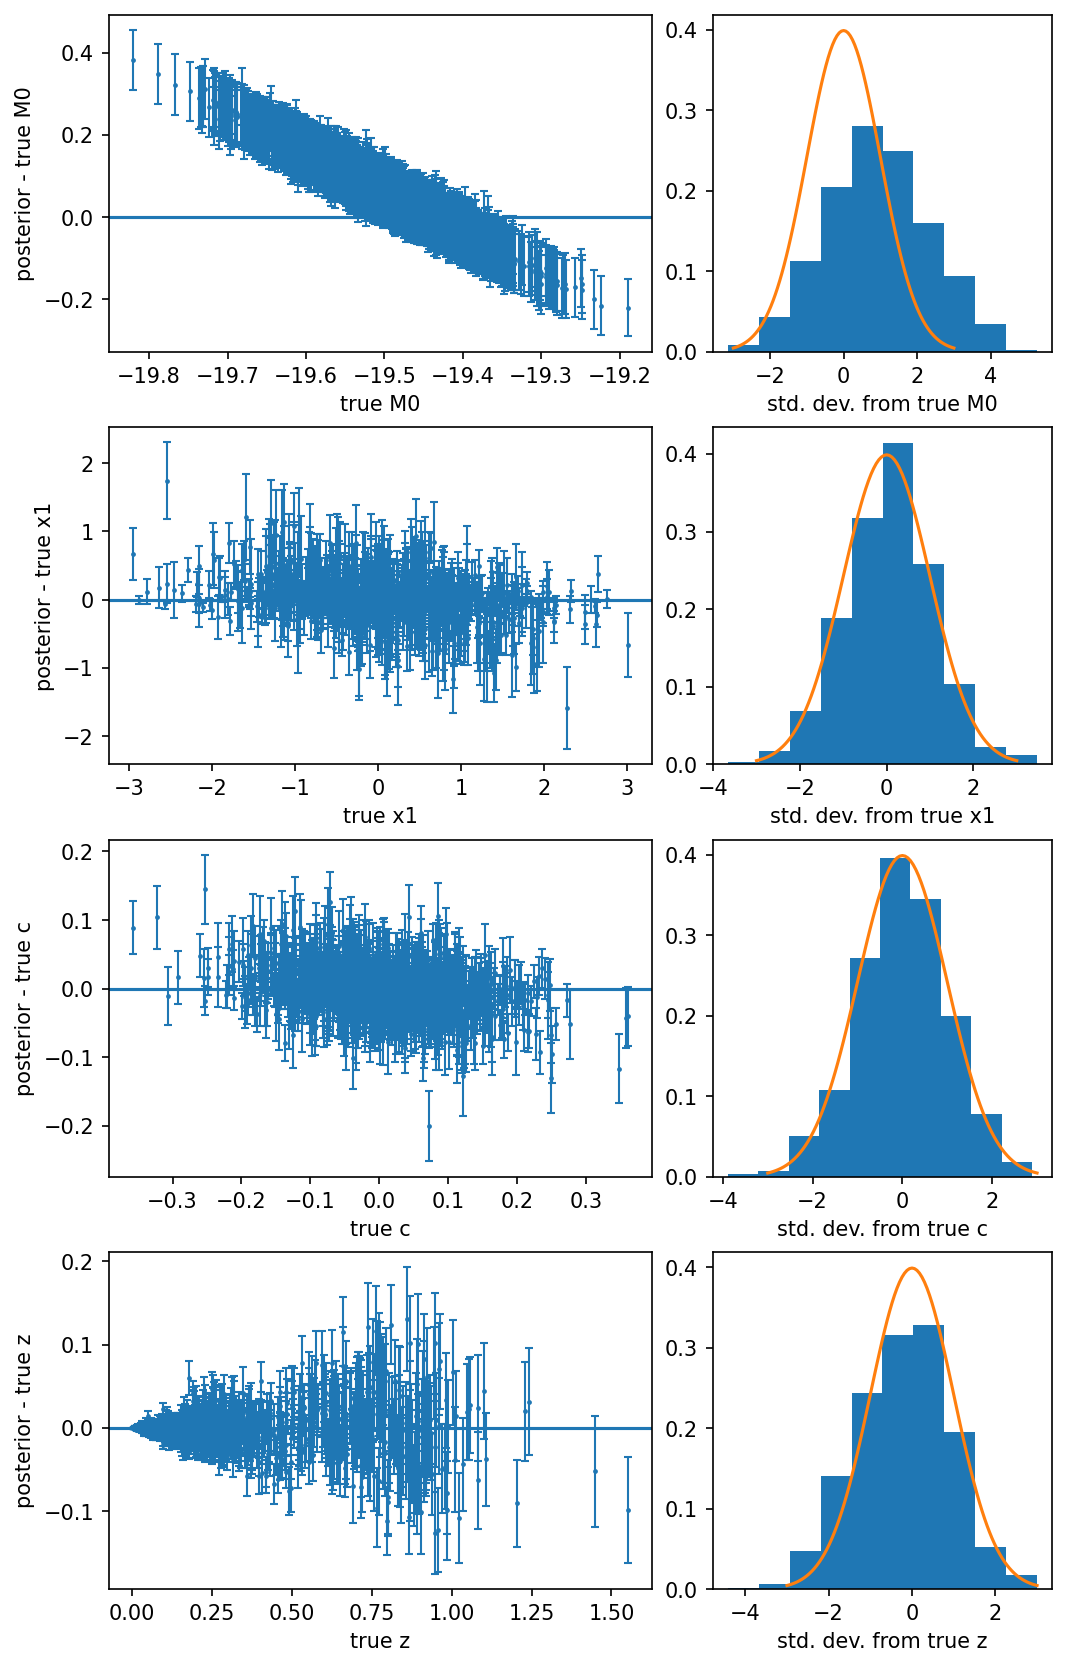

In [19]:
plotter.plot_hier();
# plt.savefig(simplesn.plotdir / (simplesn.vi_prefix + '-hier.png'));